**Notebook summary:** This notebook grabs the annual demands from NREL EFS (under the high electrification scenario) and aggregates the state level data published here up to the OEO regions. Commercial ventilation demands are taken from Markal spreadsheets to preserve the same units across ventilation technologies, existing capacity of ventilation technologies and the annual demands.

# Essentials

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import urllib.request
import os
import gzip
from scipy.interpolate import interp1d

In [3]:
region_names = dict()
region_names[1] = 'CA'
region_names[2] = 'NW'
region_names[3] = 'SW'
region_names[4] = 'TX'
region_names[5] = 'CEN'
region_names[6] = 'N_CEN'
region_names[7] = 'SE'
region_names[8] = 'MID_AT'
region_names[9] = 'NE'

In [4]:
comm_names = dict()
comm_names['COMMERCIAL AIR CONDITIONING'] = 'CSC'
comm_names['COMMERCIAL COOKING'] = 'CCK'
comm_names['COMMERCIAL LIGHTING'] = 'CLT'
comm_names['COMMERCIAL REFRIGERATION'] = 'CRF'
comm_names['COMMERCIAL SPACE HEATING'] = 'CSH'
comm_names['COMMERCIAL WATER HEATING'] = 'CWH'
comm_names['COMMERCIAL VENTILATION'] = 'CVT'
comm_names['RESIDENTIAL AIR CONDITIONING'] = 'RSC'
comm_names['RESIDENTIAL LIGHTING'] = 'RLT'
comm_names['RESIDENTIAL REFRIGERATION'] = 'RRF'
comm_names['RESIDENTIAL SPACE HEATING'] = 'RSH'
comm_names['RESIDENTIAL WATER HEATING'] = 'RWH'

# Read Raw Data

In [5]:
df_service = pd.read_csv('./rawData/service_demand.csv.gzip', compression = 'gzip')
df_service.drop(columns=['Unnamed: 0'], inplace = True)
df_state_groupings = pd.read_csv('./rawData/state_regions_cluster.csv')

# Aggregate Dervice Demands as per OEO Regions

In [7]:
# select scenario from full database
df_sel_service = df_service.loc[(df_service['SECTOR'] == 'COMMERCIAL') |
                                (df_service['SECTOR'] == 'RESIDENTIAL')]
df_sel_service = df_sel_service.loc[
    df_sel_service['SCENARIO'] ==
    'HIGH ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT']
df_sel_service.drop(columns=['SCENARIO'], inplace=True)

In [8]:
df_state_groupings['NAME'] = df_state_groupings['NAME'].str.upper()
df_service_OEO = df_sel_service.merge(df_state_groupings, left_on = 'STATE', right_on = 'NAME')

In [9]:
df_service_OEO['Region_OEO'] = df_service_OEO['Region'].map(region_names)
df_service_OEO = df_service_OEO.drop(columns = ['NAME', 'STUSPS', 'Region'])

In [10]:
df_annual_demand = df_service_OEO.groupby(['SUBSECTOR', 'YEAR', 'UNIT', 'Region_OEO']).sum().reset_index()

In [11]:
# subset_subsectors = ['COMMERCIAL AIR CONDITIONING', 'COMMERCIAL COOKING', 
#                      'COMMERCIAL LIGHTING', 'COMMERCIAL REFRIGERATION', 
#                      'COMMERCIAL SPACE HEATING', 'COMMERCIAL VENTILATION', 
#                      'COMMERCIAL WATER HEATING', 'RESIDENTIAL AIR CONDITIONING', 
#                      'RESIDENTIAL COOKING', 'RESIDENTIAL LIGHTING', 'RESIDENTIAL REFRIGERATION',
#                      'RESIDENTIAL SPACE HEATING', 'RESIDENTIAL WATER HEATING']
subset_subsectors_to_omit = ['RESIDENTIAL CLOTHES DRYING', 'RESIDENTIAL DISHWASHING', 
                             'RESIDENTIAL COOKING', 'RESIDENTIAL CLOTHES WASHING', 'RESIDENTIAL FREEZING']

In [12]:
df_annual_demand = df_annual_demand.loc[~df_annual_demand['SUBSECTOR'].isin(subset_subsectors_to_omit)]

# Ventilation Demand

In [ ]:
# Ventilation demand needs to be treated separately becuase units from EFS are not consistent with EIA and Markal

In [14]:
df_ventilation = df_annual_demand.loc[df_annual_demand['SUBSECTOR'] == 'COMMERCIAL VENTILATION'].copy()
df_ventilation.update(df_ventilation.groupby(['YEAR'])['VALUE'].apply(lambda x: x / x.sum()))

In [15]:
df_vent_demand = pd.read_excel(
    "./rawData/ventilation_demand.ods", engine="odf"
)  # Ventilation demands are taken from Markal (which in turn draws its data from the EIA)
x = df_vent_demand['Year'].to_list()
y = df_vent_demand['Demand'].to_list()
f = interp1d(x, y)
xnew = np.arange(2017, 2051)
annual_venDemand_US = {xnew[i]: f(xnew)[i] for i in range(len(xnew))}

In [16]:
df_ventilation['Demand_temp'] = df_ventilation['YEAR'].map(annual_venDemand_US)
df_ventilation['Demand'] = df_ventilation['VALUE'] * df_ventilation['Demand_temp']
df_ventilation['UNIT'] = 'TRILLION CFM'
df_ventilation.drop(columns = ['Demand_temp', 'VALUE'], inplace = True)

In [17]:
df_demand_wo_ventilation = df_annual_demand[~(df_annual_demand['SUBSECTOR'] == 'COMMERCIAL VENTILATION')].copy()
df_demand_wo_ventilation.rename(columns = {"VALUE": "Demand"}, inplace = True)

In [18]:
df_final = pd.concat([df_demand_wo_ventilation, df_ventilation])

In [19]:
df_final.rename(columns={
    "SUBSECTOR": "demand_comm",
    "YEAR": "periods",
    "UNIT": "demand_units",
    "Region_OEO": "regions",
    "Demand": "demand"
},
                inplace=True)

In [20]:
df_final['demand_comm'] = df_final['demand_comm'].map(comm_names)

In [21]:
df_final[df_final.duplicated(subset = ['demand_comm', 'periods', 'demand_units', 'regions'])]
df_final[df_final.duplicated(subset = ['demand_comm', 'periods'])]

,demand_comm,periods,demand_units,regions,demand
1,CSC,2017,TERABTU,CEN,164.018064
2,CSC,2017,TERABTU,MID_AT,255.286587
3,CSC,2017,TERABTU,NE,94.128520
4,CSC,2017,TERABTU,NW,11.300634
5,CSC,2017,TERABTU,N_CEN,148.496519
...,...,...,...,...,...
1831,CVT,2050,TRILLION CFM,NW,16.665440
1832,CVT,2050,TRILLION CFM,N_CEN,52.336583
1833,CVT,2050,TRILLION CFM,SE,81.971919
1834,CVT,2050,TRILLION CFM,SW,21.241059


In [22]:
df_final[['regions', 'periods', 'demand_comm', 'demand', 'demand_units']].to_csv('./TablesForDB/annualDemand_buildings_regional.csv')

# Miscellaneous Scripts

## Table for OEO documentation

In [ ]:
df_table = df_annual_demand[['SUBSECTOR', 'UNIT']].drop_duplicates().reset_index(drop = True)
df_table['Existing Capacity'] = 'PJ'
df_table['Efficiency (EIA)'] = ['COP, EER (Btu/h/W), IEER (Btu/h/W)', 'cooking energy efficiency (%)', 'system efficacy (lm/W)', 'indexed annual efficiency','COP, TE (%), AFUE (%)', 'no efficiency published in EIA', 'TE (%), SEF, COP', 'SEER (Btu/Wh), EER (Btu/W/h), COP','system efficacy (lm/W)', 'no efficiency published in EIA','AFUE (%), TE (%), HSPF (Btu/Wh), COP, HHV', 'UEF, SEF']
df_table = df_table.rename(columns={'UNIT': 'Demand (NREL EFS)', 'Existing Capacity': 'Exst Capacity (EPA)'})

In [ ]:
df_table

## Grab raw data by running this cell

In [2]:
# if 'service_demand.csv' not in os.listdir():
#     url = 'https://data.nrel.gov/system/files/92/service_demand.csv.gzip'
#     filename =  os.getcwd() + '/' + url.split('/') [-1]
#     r = urllib.request.urlretrieve(url,filename)

#     fp = open('service_demand.csv', 'wb')
#     with gzip.open(filename, 'rb') as f:
#         data = f.read()
#     fp.write(data)
#     fp.close()

## Miscellaneous code cells

In [ ]:
# end_use = 'RESIDENTIAL WATER HEATING'
# df_annual_demand.loc[(df_annual_demand['SUBSECTOR'] == end_use) & (df_annual_demand['YEAR'] == 2017)]['VALUE'].agg(['sum', 'max', 'min'])
# df_annual_demand.loc[(df_annual_demand['SUBSECTOR'] == end_use) & (df_annual_demand['YEAR'].isin([2017, 2018, 2019]))]['VALUE'].agg(['sum', 'max', 'min'])
# df_annual_demand.loc[df_annual_demand['SUBSECTOR'] == end_use]
# df_annual_demand.loc[~df_annual_demand['UNIT'].str.contains('BTU')][['SUBSECTOR', 'UNIT']].drop_duplicates()
# df_annual_demand.loc[(df_annual_demand['SUBSECTOR'] == 'RESIDENTIAL LIGHTING') & (df_annual_demand['YEAR'] == 2017)]['VALUE'].sum()
# # df_annual_demand.loc[(df_annual_demand['SUBSECTOR'] == 'RESIDENTIAL REFRIGERATION') & (df_annual_demand['YEAR'].isin([2017, 2018, 2019]))]['VALUE'].agg(['sum', 'max', 'min'])
# df_annual_demand.loc[(df_annual_demand['SUBSECTOR'] == 'COMMERCIAL VENTILATION') & (df_annual_demand['YEAR'] == 2017)]

In [ ]:
# for region in df_temp.Region_OEO.unique():
#     df_plot = df_temp.loc[df_temp['Region_OEO'] == region].reset_index()
#     plt.plot(df_plot["YEAR"], df_plot["VALUE"], '--', label=region)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 1.0, 'Residential Sector - CEN')

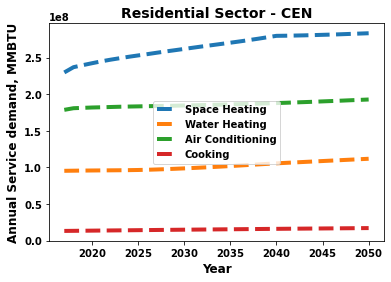

In [261]:
temp_store = df_service_OEO[['SUBSECTOR', 'UNIT']].drop_duplicates()
temp_store_1 = temp_store.loc[temp_store.UNIT.str.endswith('BTU')]
list_to_sub_res = list(temp_store_1.loc[temp_store_1['SUBSECTOR'].str.startswith('RES')]['SUBSECTOR'])
list_to_sub_comm = list(temp_store_1.loc[temp_store_1['SUBSECTOR'].str.startswith('COMM')]['SUBSECTOR'])

df_temp = df_temp.loc[df_temp['Region_OEO'] == 'CEN']

for subsector in list_to_sub_res:
    df_plot = df_temp.loc[df_temp['SUBSECTOR'] == subsector].reset_index()
    plt.plot(df_plot["YEAR"], df_plot["VALUE"], '--', label=subsector, linewidth = 4)


SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.xlabel(r'\textbf{Year}')
# plt.ylabel(r'\textbf{Service demand, MMBTU}')
plt.xlabel('Year', fontweight = "bold")
plt.ylabel('Annual Service demand, MMBTU', fontweight = "bold")

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
labels = ['Space Heating', 'Water Heating', 'Air Conditioning', 'Cooking']
plt.legend(labels, loc = 'center', bbox_to_anchor=(0.5, 0.5))
plt.title('Residential Sector - CEN', fontweight="bold", fontsize = 14)

In [19]:
df_service_OEO[['SUBSECTOR', 'UNIT']].drop_duplicates()

,SUBSECTOR,UNIT
0,RESIDENTIAL SPACE HEATING,MMBTU
2652,RESIDENTIAL LIGHTING,KILOLUMEN_HOUR
2754,RESIDENTIAL WATER HEATING,MMBTU
4352,RESIDENTIAL AIR CONDITIONING,MMBTU
4760,RESIDENTIAL REFRIGERATION,CUBIC_FEET
4964,RESIDENTIAL FREEZING,CUBIC_FEET
5032,RESIDENTIAL COOKING,MMBTU
5236,RESIDENTIAL CLOTHES WASHING,CUBIC_FOOT_CYCLE
5338,RESIDENTIAL CLOTHES DRYING,LB
5542,RESIDENTIAL DISHWASHING,CYCLE
